In [1]:
import torch
import torchvision

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

数据集

In [2]:
transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])
dataset=torchvision.datasets.mnist.MNIST(root='./data',train=True,download=True,transform=transform)

In [3]:
img,label=dataset[0]
print(f'img={img.shape} label={label}')

img=torch.Size([1, 28, 28]) label=5


模型

In [4]:

from torch.nn import functional as F

class VAE(torch.nn.Module):
    def __init__(self,input_size,hidden_size,latent_size):
        super().__init__()
        
        self.fc1=torch.nn.Linear(in_features=input_size,out_features=hidden_size)
        self.fc_mu=torch.nn.Linear(in_features=hidden_size,out_features=latent_size)
        self.fc_logvar=torch.nn.Linear(in_features=hidden_size,out_features=latent_size)
        
        self.fc2=torch.nn.Linear(in_features=latent_size,out_features=hidden_size)
        self.fc3=torch.nn.Linear(in_features=hidden_size,out_features=input_size)
    
    def reparameterize(self,mu,logvar):
        '''
        计算标准差std
        1、log_var * 0.5 相当于 log(方差) * 0.5
        2、根据对数性质log(a^n) = n * log(a)，这等于 log(方差^(1/2))
        '''
        std=torch.exp(logvar*0.5)
        eps=torch.randn_like(mu)
        return mu+eps*std
    
    def forward(self,x):
        hidden=F.relu(self.fc1(x.view(x.size(0),-1)))
        mu=self.fc_mu(hidden)
        logvar=self.fc_logvar(hidden)
        
        z=self.reparameterize(mu,logvar)
        
        recon_x=F.relu(self.fc2(z))
        recon_x=self.fc3(recon_x)
        return F.sigmoid(recon_x).view(*x.size()),mu,logvar
    
    def decode(self,z):
        recon_x=F.relu(self.fc2(z))
        recon_x=self.fc3(recon_x)
        return F.sigmoid(recon_x)


训练

In [5]:
model=VAE(input_size=1*28*28,hidden_size=256,latent_size=20).to(device)
dataloader=torch.utils.data.DataLoader(dataset,batch_size=1024,shuffle=True)
optimizer=torch.optim.AdamW(model.parameters(),lr=1e-2,weight_decay=1e-4)

In [6]:
import os
import datetime
from torch.utils.tensorboard import SummaryWriter

tensorboard=SummaryWriter(log_dir=f'./runs/vae/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}')

iters=0
epoch=0
model.train()
for i in range(200):
    for batch_img,batch_labels in dataloader:
        batch_img=batch_img.to(device)
        batch_labels=batch_labels.to(device)
        recon_x,mu,logvar=model(batch_img)
        optimizer.zero_grad()
        recon_loss=torch.sum(torch.nn.functional.binary_cross_entropy(recon_x,batch_img,reduction='none'),dim=(1,2,3))
        kl_loss=-0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp(),dim=-1)
        loss=torch.mean(recon_loss+i/200*kl_loss)
        loss.backward()
        optimizer.step()
        tensorboard.add_scalar('vae/loss',loss.item(),iters)
        tensorboard.add_scalar('vae/recon_loss',torch.mean(recon_loss).item(),iters)
        tensorboard.add_scalar('vae/kl_loss',torch.mean(kl_loss).item(),iters)
        iters+=1
    torch.save(model.state_dict(),'.model.pt')
    os.replace('.model.pt','model.pt')
    print(f'epoch={epoch} loss={loss.item()}')
    epoch+=1

epoch=0 loss=144.9186553955078
epoch=1 loss=108.69416046142578
epoch=2 loss=92.52863311767578
epoch=3 loss=86.7397689819336
epoch=4 loss=81.71833038330078
epoch=5 loss=79.4777603149414
epoch=6 loss=78.5658950805664
epoch=7 loss=77.74374389648438
epoch=8 loss=80.99681091308594
epoch=9 loss=78.0080337524414
epoch=10 loss=75.71537017822266
epoch=11 loss=77.44837188720703
epoch=12 loss=77.23356628417969
epoch=13 loss=76.9455795288086
epoch=14 loss=77.8197021484375
epoch=15 loss=77.3636703491211
epoch=16 loss=75.82036590576172
epoch=17 loss=78.94355010986328
epoch=18 loss=77.3430404663086
epoch=19 loss=77.44664764404297
epoch=20 loss=74.92322540283203
epoch=21 loss=77.59883880615234
epoch=22 loss=78.61006927490234
epoch=23 loss=79.47471618652344
epoch=24 loss=77.85454559326172
epoch=25 loss=77.69974517822266
epoch=26 loss=78.1929931640625
epoch=27 loss=79.71031188964844
epoch=28 loss=76.46756744384766
epoch=29 loss=78.28387451171875
epoch=30 loss=78.37136840820312
epoch=31 loss=77.577331542

复原

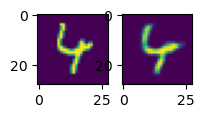

In [73]:
import matplotlib.pyplot as plt
import random

model.eval()
with torch.no_grad():
    img,_=dataset[random.randint(0,len(dataset))]
    recon_x,mu,logvar=model(img.unsqueeze(0).to(device))

plt.figure(figsize=(2,2))
plt.subplot(1,2,1)
plt.imshow(img.view(28,28).numpy())
plt.subplot(1,2,2)
plt.imshow(recon_x.view(28,28).cpu().numpy())

生成

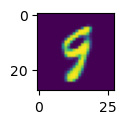

In [92]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    latent=torch.randn(1,20).to(device)
    recon_x=model.decode(latent)
plt.figure(figsize=(1,1))
plt.imshow(recon_x.view(28,28).cpu().numpy())